# Covariate shift detection and correction example

Demo for the DIPA Data61 Course: Model Validation, Uncertainty and Missing Data

Dependencies:

- numpy
- scipy
- jupyter
- matplotlib
- scikit learn


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as pl
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, log_loss
from IPython.display import display, HTML

%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})
np.random.seed(666)  # fix random seed
FIGSIZE = (16, 9)

## Generate data

Let's keep going with the cancer diagnosis problem, imagine the blue points are the positive cancer diagnosis.
10% of the sample have cancer, 90% do not. Let's generate two imaginary features, $\mathbf{x}$, that are somewhat predictive of a cancer diagnosis, $y \in \{0, 1\}$ (0 no cancer, 1 cancer).

The catch this time, is that our **training/validation** and **query** data come from two different populations!

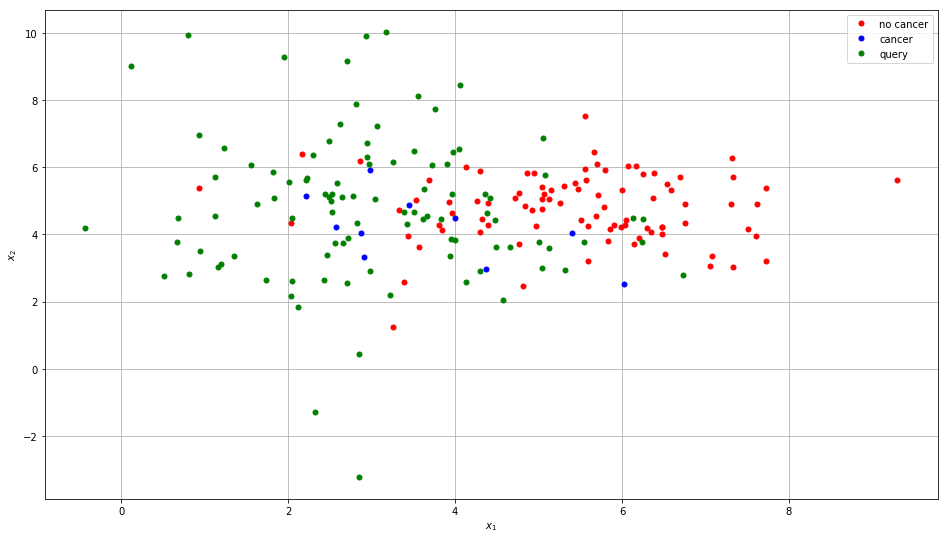

In [8]:
# class 1
n1 = 90 
mean1 = [5, 5]
cov1 = [
    [2.0, -0.1],
    [-0.1,  1.0]
]

X1 = np.random.multivariate_normal(mean1, cov1, n1)
Y1 = np.zeros(n1)

# class 2
n2 = 10
mean2 = [4, 3.7]
cov2 = [
    [1.0, -0.3],
    [-0.3,  0.5]
]

X2 = np.random.multivariate_normal(mean2, cov2, n2)
Y2 = np.ones(n2)

# Query data (unknown class)
nq = 100
meanq = [3., 5.]
covq = [
    [2.0, 0.],
    [0.,  4.0]
]

Xq = np.random.multivariate_normal(meanq, covq, nq)
Yq = np.zeros(nq)

# Mix them together
Xt = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))
Yt = np.ones(n2 + n1)

Xall = Xt = np.vstack((Xt, Xq))
Yall = np.concatenate((Yt, Yq))


# Plot
def plot_data():
    pl.plot(*X1.T, 'r.', label='no cancer', markersize=10)
    pl.plot(*X2.T, 'b.', label='cancer', markersize=10)
    pl.plot(*Xq.T, 'g.', label='query', markersize=10)
    pl.xlabel('$x_1$')
    pl.ylabel('$x_2$')
    pl.legend()
    pl.show()

pl.figure(figsize=FIGSIZE)
pl.grid()
plot_data()